# Grouping Financial instruments.

## Objective
Here in this project we choose a financial data from yahoo finance. We create a data set by using this data and some feature engineering.

The main objective of this project is to capture behaviour of different financial instruments in the market. Mainly to cluster the instruments into three clusters which may be 
- High risk and high return
- Low risk and low return
- Neutral
    
We create out data capturing the return, volatility of the prices and volume and group them into clusters and see if there is any groups. 

This is usefull in portfolio creation and analysis. You can analyse how the funds are allocated to different sectors to eliminate risk. 

## Data

The data contain `Price`, `Open`, `High`, `Low`, `Close` and `Volume` for different stocks in SP&500 and additional instruments such as bonds, crypto and indexes (tickers) from 2018-01-01 to 2023-01-01. 

Using this dataset, we create our own dataset.
We take the `Close` from the dataset for all the tickers. We create new features such as
1. `Returns`: annual average of the close price.
2. `Volatility`: annual standard deviation of the stocks.
3. `Sharpe_ratio`: the ratio of the above two.
4. `Momentum_30` : thirty day average of the returns.

These four should capture the price movements fairly.

## Exploratory Data Analysis
### Data Cleaning
There is not much to do here. There are some missing values, which we have dropped. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('finance_raw.csv', header=[0,1])

In [3]:
print('First five rows of the raw data:')
data.head()

First five rows of the raw data:


Ticker        GEN                                              \
        Price       Open       High        Low      Close     Volume   
0        Date        NaN        NaN        NaN        NaN        NaN   
1  2018-01-01        NaN        NaN        NaN        NaN        NaN   
2  2018-01-02  14.200767  14.597745  14.095240  14.527394  5539600.0   
3  2018-01-03  14.477144  14.658045  14.421869  14.527394  4273700.0   
4  2018-01-04  14.673120  14.698245  14.467094  14.557544  5283000.0   

         CSX                                   ...        AXP             \
        Open       High        Low      Close  ...       Open       High   
0        NaN        NaN        NaN        NaN  ...        NaN        NaN   
1        NaN        NaN        NaN        NaN  ...        NaN        NaN   
2  16.920730  17.224896  16.735189  17.136688  ...  90.228814  90.228814   
3  17.081929  17.413468  17.051513  17.352636  ...  89.785508  90.255972   
4  17.443888  17.629429  17.227930  17.270514  ...  90.819560  92.290398   

                                          CHD                        \
         Low      Close     Volume       Open       High        Low   
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2  88.862669  89.514076  2746700.0  45.869048  45.978979  45.264423   
3  89.586466  90.065979  2976400.0  45.346871  45.429320  44.760569   
4  90.710613  91.564056  3122000.0  45.127003  45.823240  45.099521   

                         
       Close     Volume  
0        NaN        NaN  
1        NaN        NaN  
2  45.282745  4942300.0  
3  44.989594  1650000.0  
4  45.749950  1495700.0  

[5 rows x 2622 columns]

In [4]:
tickers = [np.array(data.columns)[i][0] for i in range(1,len(data.columns))]
all_tickers = list(set(tickers))

In [5]:
# def warn(*args, **kwargs):
#     pass
import warnings
# warnings.warn = warn
warnings.filterwarnings("ignore")

returns_list=[]
volatility_list=[]
sharpe_rattio_list=[]
momentum_30_list=[]
vol_price_corr_list=[]
vol_volatility_list=[]
for ticker in all_tickers:
    try:
        prices = data[ticker]['Close']
        volume = data[ticker]['Volume']
        
        returns = prices.pct_change().mean() * 252
        volatility = prices.pct_change().std() * np.sqrt(252)
        sharpe_ratio = returns / volatility
        momentum_30 = prices.pct_change(30).mean()
        vol_volatility = np.log(volume.pct_change().std() * np.sqrt(252))
        vol_price_corr = prices.pct_change().corr(volume)


        returns_list.append(returns)
        volatility_list.append(volatility)
        sharpe_rattio_list.append(sharpe_ratio)
        momentum_30_list.append(momentum_30)
        vol_volatility_list.append(vol_volatility)
        vol_price_corr_list.append(vol_price_corr)

    except KeyError:
        print(f'Skpping {ticker} (no data)')
        continue

In [6]:
df = pd.DataFrame({'Ticker':all_tickers[:len(returns_list)],
                   'Returns':returns_list,
                   'Volatility':np.log(volatility_list),
                   'Sharpe_ratio':sharpe_rattio_list,
                   'Momentum_30':momentum_30_list,
                   # 'Log_vol_volatility':vol_volatility_list,
                   # 'Volume_price_corr':vol_price_corr_list
                  }).dropna().set_index('Ticker')

print('First five rows of the data created:')
df.head()

First five rows of the data created:


,Returns,Volatility,Sharpe_ratio,Momentum_30
Ticker,,,,
COF,0.066216,-1.033219,0.186073,0.005968
DVN,0.211407,-0.686904,0.420182,0.028863
WTW,0.105737,-1.488234,0.468338,0.011023
ZTS,0.130218,-1.455466,0.558176,0.014235
DHR,0.174335,-1.486335,0.770709,0.019637


## Data scaling
We standardise the data using standard scarar. 

In [7]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
df_scaled = scalar.fit_transform(df[df.columns])
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

print('First five columns of the scaled data:')
df_scaled.head()

First five columns of the scaled data:


,Returns,Volatility,Sharpe_ratio,Momentum_30
Ticker,,,,
COF,-0.481540,0.708779,-0.831211,-0.586431
DVN,1.080314,1.834141,0.199638,1.359350
WTW,-0.056400,-0.769811,0.411685,-0.156826
ZTS,0.206944,-0.663329,0.807267,0.116211
DHR,0.681519,-0.763639,1.743113,0.575319


There is some skewness in the distribution. We will not do anything about it because it might be important for clustering. 

In [8]:
df_scaled.skew()

Returns         2.671394
Volatility      0.245427
Sharpe_ratio    0.250710
Momentum_30     3.780119
dtype: float64

Now we train four models.
1. Kmeans
2. DBSCAN
3. Hirarchical Agglomerative Clustering and
4. Meanshift

We fit and predict the and add the results as columns to dataframe. 

```python

# Kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=22)
df['Cluster_Kmeans'] = kmeans.fit_predict(df_scaled)

# DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.09, min_samples=4, p=2)
df['Cluster_DBSCAN'] = dbscan.fit_predict(df_scaled)

#HAC
from sklearn.cluster import AgglomerativeClustering
hac = AgglomerativeClustering(n_clusters=5, linkage='ward')
df['Cluster_Hierarchical'] = hac.fit_predict(df_scaled)

# Meanshift
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(df_scaled, quantile=.03, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True)
df['Cluster_Meanshift'] = ms.fit_predict(df_scaled)
```

We use silhouette score for scoring.
```python
from sklearn.metrics import silhouette_score

print("K-Means Silhouette:", silhouette_score(df_scaled, df['Cluster_Kmeans']))
print("DBSCAN Silhouette:", silhouette_score(df_scaled, df['Cluster_DBSCAN']))
print("Hierarchical Agglomatative Silhouette:", silhouette_score(df_scaled, df['Cluster_Hierarchical']))
print("Meanshift Silhouette:", silhouette_score(df_scaled, df['Cluster_Meanshift']))
```

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=22)
df['Cluster_Kmeans'] = kmeans.fit_predict(df_scaled)

In [10]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.09, min_samples=4, p=2)
df['Cluster_DBSCAN'] = dbscan.fit_predict(df_scaled)

In [11]:
from sklearn.cluster import AgglomerativeClustering
hac = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['Cluster_Hierarchical'] = hac.fit_predict(df_scaled)

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(df_scaled, quantile=.03, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True)
df['Cluster_Meanshift'] = ms.fit_predict(df_scaled)

In [13]:
from sklearn.metrics import silhouette_score

print("K-Means Silhouette:", silhouette_score(df_scaled, df['Cluster_Kmeans']))
print("DBSCAN Silhouette:", silhouette_score(df_scaled, df['Cluster_DBSCAN']))
print("Hierarchical Agglomatative Silhouette:", silhouette_score(df_scaled, df['Cluster_Hierarchical']))
print("Meanshift Silhouette:", silhouette_score(df_scaled, df['Cluster_Meanshift']))


K-Means Silhouette: 0.35742558996340684
DBSCAN Silhouette: -0.4275794744532688
Hierarchical Agglomatative Silhouette: 0.3688665173173335
Meanshift Silhouette: 0.2261673564546393


## Data reduction for visualization
Now we use PCA and reduce the data dimension to 2D and plot to see how clusters are formed.
```python
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
```

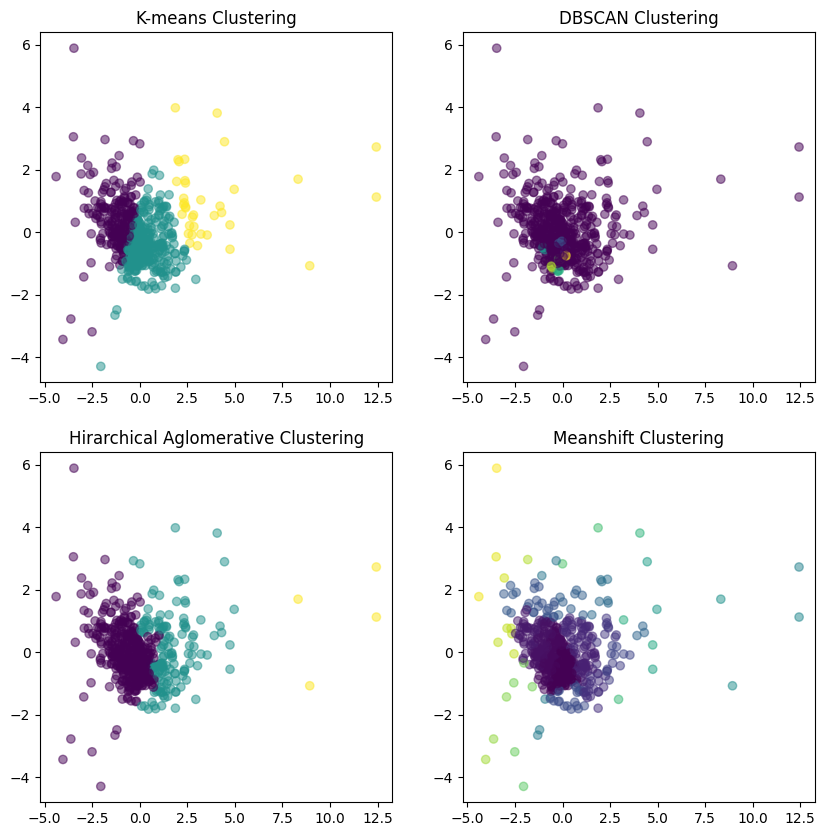

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
ax[0].scatter(df_pca[:,0], df_pca[:,1],
            c=df['Cluster_Kmeans'],
            cmap='viridis', alpha=0.5)
ax[0].set_title('K-means Clustering')

ax[1].scatter(df_pca[:,0], df_pca[:,1],
            c=df['Cluster_DBSCAN'],
            cmap='viridis', alpha=0.5)
ax[1].set_title('DBSCAN Clustering')

ax[2].scatter(df_pca[:,0], df_pca[:,1],
            c=df['Cluster_Hierarchical'],
            cmap='viridis', alpha=0.5)
ax[2].set_title('Hirarchical Aglomerative Clustering')

ax[3].scatter(df_pca[:,0], df_pca[:,1],
            c=df['Cluster_Meanshift'],
            cmap='viridis', alpha=0.5)
ax[3].set_title('Meanshift Clustering')

plt.show()

As expected the Kmeans and HAC has done a better job than DBSCAN and Meanshift.

Now we do the same i.e., data reduction via TSNE and plot the clusters.
```python
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,
        init="pca",
        n_iter=500,
        n_iter_without_progress=150,
        perplexity=12,
        random_state=2)

df_tsne = tsne.fit_transform(df_scaled)
```

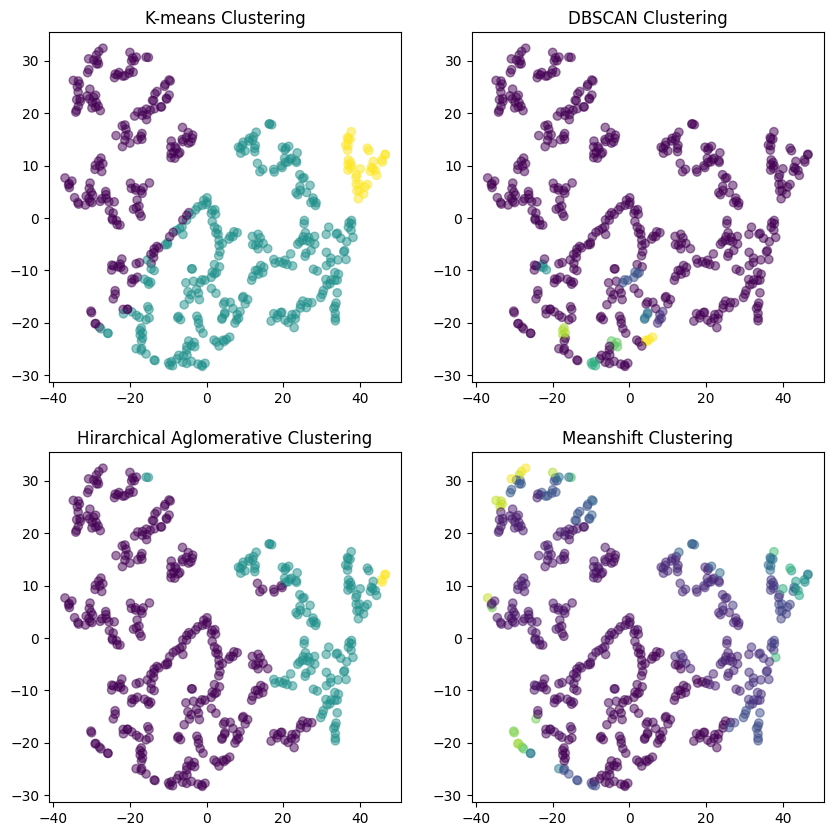

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,
        init="pca",
        n_iter=500,
        n_iter_without_progress=150,
        perplexity=12,
        random_state=2)

df_tsne = tsne.fit_transform(df_scaled)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
ax[0].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_Kmeans'],
            cmap='viridis', alpha=0.5)
ax[0].set_title('K-means Clustering')

ax[1].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_DBSCAN'],
            cmap='viridis', alpha=0.5)
ax[1].set_title('DBSCAN Clustering')

ax[2].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_Hierarchical'],
            cmap='viridis', alpha=0.5)
ax[2].set_title('Hirarchical Aglomerative Clustering')

ax[3].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_Meanshift'],
            cmap='viridis', alpha=0.5)
ax[3].set_title('Meanshift Clustering')

plt.show()

Again here we clearly see that Meanshift and HAC has done a better job compared to the other two.

## Clustering after reducing data dimension using TSNE

Now we use the dimension reduced dataset `data_tsne` and apply clustering algorithms to this dataset.

```python
# Kmeans
df['Cluster_tsne_Kmeans'] = kmeans.fit_predict(df_tsne)

# DBSCAN
dbscan_tsne = DBSCAN(eps=6, min_samples=5, p=2)
df['Cluster_tsne_DBSCAN'] = dbscan_tsne.fit_predict(df_tsne)

# HAC
df['Cluster_tsne_Hierarchical'] =  hac.fit_predict(df_tsne)

# Meanshift
bandwidth = estimate_bandwidth(df_tsne, quantile=.2, n_samples=5000)
ms_tsne = MeanShift(bandwidth=bandwidth,bin_seeding=True)
df['Cluster_tsne_Meanshift'] = ms_tsne.fit_predict(df_tsne)
```

In [16]:
df['Cluster_tsne_Kmeans'] = kmeans.fit_predict(df_tsne)

dbscan_tsne = DBSCAN(eps=6.55, min_samples=1, p=1)
df['Cluster_tsne_DBSCAN'] = dbscan_tsne.fit_predict(df_tsne)

df['Cluster_tsne_Hierarchical'] =  hac.fit_predict(df_tsne)

bandwidth = estimate_bandwidth(df_tsne, quantile=.19, n_samples=1000)
ms_tsne = MeanShift(bandwidth=bandwidth,bin_seeding=True)
df['Cluster_tsne_Meanshift'] = ms_tsne.fit_predict(df_tsne)

In [17]:
print("K-Means Silhouette:", silhouette_score(df_tsne, df['Cluster_tsne_Kmeans']))
print("DBSCAN Silhouette:", silhouette_score(df_tsne, df['Cluster_tsne_DBSCAN']))
print("Hierarchical Agglomatative Silhouette:", silhouette_score(df_tsne, df['Cluster_tsne_Hierarchical']))
print("Meanshift Silhouette:", silhouette_score(df_tsne, df['Cluster_tsne_Meanshift']))


K-Means Silhouette: 0.4788883
DBSCAN Silhouette: -0.09981778
Hierarchical Agglomatative Silhouette: 0.47888383
Meanshift Silhouette: 0.47066012


Again silhouette scores are calculated. Now we see that Kmeans, HAC, Meanshift performs better in this dimension reduced data. However DBSCAN eventhough has good score, identifies only two clusters. 

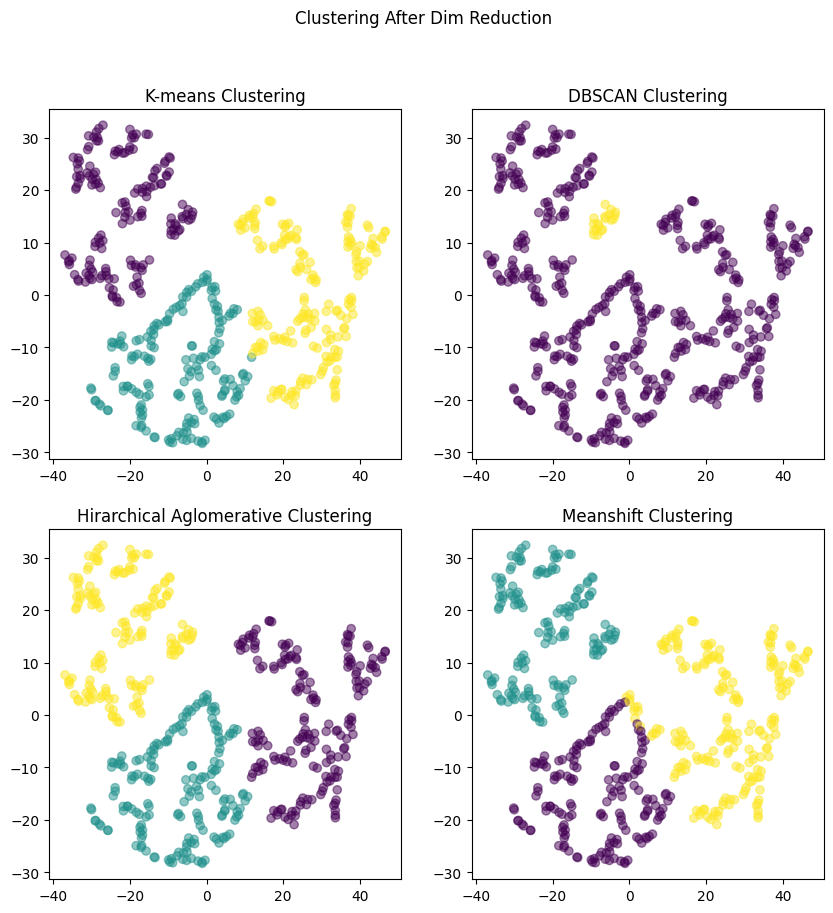

In [18]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
ax[0].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_tsne_Kmeans'],
            cmap='viridis', alpha=0.5)
ax[0].set_title('K-means Clustering')

ax[1].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_tsne_DBSCAN'],
            cmap='viridis', alpha=0.5)
ax[1].set_title('DBSCAN Clustering')

ax[2].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_tsne_Hierarchical'],
            cmap='viridis', alpha=0.5)
ax[2].set_title('Hirarchical Aglomerative Clustering')

ax[3].scatter(df_tsne[:,0], df_tsne[:,1],
            c=df['Cluster_tsne_Meanshift'],
            cmap='viridis', alpha=0.5)
ax[3].set_title('Meanshift Clustering')

fig.suptitle('Clustering After Dim Reduction')
plt.show()

## Observations
- With the entire data, the Kmeans and HAC does a pretty good job in clustering. This is mainly because we are kind of know how many clusters we are lookin for.
- With the low dimension data, all the model performs better except DBSCAN which could not identify the third cluster.

## Recommendation
I recommend the Kmeans algorithm for the problem concerned here. This is because of three reasons.
1. It is intuitive and easy to understand and explain.
2. We already know the number of clusters. So it is better to use Kmeans as it is simple.
3. It does a eqivalently good job compared to other models both in full and reduced data.

## Further steps
* We can engineer more features like 'Average volume traded', 'Volume volatility', 'Cumulative returns' etc. to better capture risk and return relations more accurately.
* We can increase the data set with more tickers.
* We can tune the parameters of the model to even perform better.
* We can analyse the clusters formed after dimension reduction and look for the meaning for those cluster. Right now we only know the data forms three clusters, what they mean we do not know. They can be as our problem stated are the clusters of
    - High risk and high return
    - Low risk and low return
    - Neutral

In [19]:
!jupyter nbconvert yahoo_fin.ipynb --to webpdf --theme=light --no-input

[NbConvertApp] Converting notebook yahoo_fin.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 974652 bytes to yahoo_fin.pdf


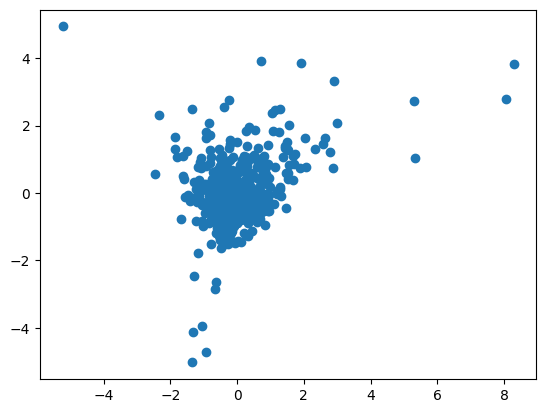

In [22]:
plt.scatter(df_scaled['Returns'], df_scaled['Volatility'])